### Three year summary Lake Geneva

#### Notebook 1

__Purpose:__ Present an analysis method for survey results from beach litter inventories on Lake Geneva.

__Background:__ This is in the context of the global movement to reduce plastic debris in the maritime environment. Riverine inputs are major contributors of plastic debris (and all types of refuse) to the oceans. This is an analysis of the data collected on the shores of Lake Geneva over a three year period. The maritime protocol was modified in very specific ways to adjust for the local geography and population density.

#### Research question: Is this a representative sample ?

There is a push to quantify the amounts of plastic trash in the environment. It would be impossible to pick up every piece of trash in the environment and count it (that would solve the problem though). Extrapolating from economic and population data is one way to obtain a macro-view of the problem. But the margin of error on these type of calculations makes them unsuitable for identifying trends on a local or regional level.

If sampling all the trash is not possibile, what if we sample as much as possible and see what that looks like? The following questions could be answered:

1. What does the distribution of survey results look like?
2. Do different groups of people produce different survey results?
3. How different are the survey results from one location to another?
4. What are the most abundant objects?
5. How different are the survey results year over year?

These series of notebooks will try to answer those questions. 

In [1]:
# import numpy as np
import json
import csv
import datetime
import collections
# import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import geopandas
import os
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatch
from matplotlib.lines import Line2D
from Utilities.utility_functions import *
idx = pd.IndexSlice

In [2]:
# The data is off of the API at https://mwshovel.pythonanywhere.com/dirt/api_home.html 
# You will have the opportunity to save the data locally
# get some file structures in place

# Required variables:
folders = ["Data", "Charts", "Utilities"]
here = os.getcwd()

# check for existing and if not make folders
check_for_folders(folders, here)

# make a dictionary to call path by directory name
my_folders = make_folders(folders, here)

Directory already in place


In [3]:
# save the data to local from the api

# required variables:
end_points = (
    ("beach_info","http://mwshovel.pythonanywhere.com/dirt/beaches/Lac-L%C3%A9man/"),
    ("all_data", "https://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/")
)
# def checkForData():

# get and put the data to local
putTheDataToLocal(end_points, here)

['/home/mw-shovel/three_year_final/Data/beach_info.json', '/home/mw-shovel/three_year_final/Data/all_data.json']


In [4]:
# Read the JSON data in from local
# there is no need to hit the server a million times

# required variables
the_jsons = [
    '/home/mw-shovel/three_year_final/Data/beach_info.json',
    '/home/mw-shovel/three_year_final/Data/all_data.json'
]

# all the survey results by code, location, date, project:
my_survey_results = jsonFileGet(the_jsons[1])
def changeProjectName(aList, otherList, projectName):
    aNewList = []   
    for eachDict in aList:       
        if eachDict["location_id"] in otherList:
            eachDict['project_id'] = projectName
            aNewList.append(eachDict)
        else:
            aNewList.append(eachDict)
    return aNewList
            
location_list = ["Plage-de-St-Sulpice", "Parc-des-Pierrettes",  "Tiger-duck-beach", "Saint-Sulpice"]
project_name = "tiger-duck"
my_survey_resultsx = changeProjectName(my_survey_results, location_list, project_name)

# all the location information:
beach_info = jsonFileGet(the_jsons[0])

# make a data frame:
the_survey_results = pd.DataFrame(my_survey_resultsx)    

In [5]:
# making a pcs/m column:
the_survey_results["pcs_m"] = the_survey_results["quantity"]/the_survey_results["length"]

# making a month, day and year column from a datetime object
# makes sorting easier
the_survey_results["py_date"] = pd.to_datetime(the_survey_results["date"])
the_survey_results["py_month"] = the_survey_results["py_date"].dt.month
the_survey_results["py_year"] = the_survey_results["py_date"].dt.year
the_survey_results["py_day"] = the_survey_results["py_date"].dt.weekday

In [6]:
#### one df for abundance and one df for density:
abundance = the_survey_results[["project_id", "location_id", "date","py_date", "py_month", "py_year", "code_id", "quantity"]].copy()
density = the_survey_results[["project_id", "location_id", "date","py_date", "py_day","py_month", "py_year", "code_id", "pcs_m"]].copy()  

In [7]:
year_one_end_start = convertStringToDate([("2015-11-15", "2016-11-14")])
year_two_end_start = convertStringToDate([("2016-11-15", "2017-11-14")])
year_three_end_start=convertStringToDate([("2017-11-15", "2018-11-14")])
project_start_end = convertStringToDate([("2015-11-15", "2018-11-14")])
start_date = datetime.datetime.strptime("2015-11-15", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2018-11-14", "%Y-%m-%d")
project_names = abundance.project_id.unique()
def getAnnualSummaries(aList, aDf):
    local = aDf.index.get_level_values('project_id')
    projects = [x for x in aList if x in local]
    out_put = {}
    for name in projects:
        the_df = aDf.loc[idx[name,:,:],:]
        the_summary = the_df.describe()
        the_total = the_df.quantity.sum()
        the_dict = dict(
            project=name,
            data=the_df,
            summary=the_summary,
            the_total=the_total
        )
        out_put.update({name:the_dict})
    combined = dict(
        project='All',
        data=aDf,
        the_total=aDf.quantity.sum(),
        summary=aDf.describe()
    )
    out_put.update({'All':combined})
    return out_put

### Results: Number of samples, sample locations, profile of participants...

#### Samples grouped by participants

There were/are many groups on the lake shore concerned by this problem. The data originates from five distinct groups:

1. Students from École interantionale de Genève
2. Students from The EPFL Solid waste engineering course
3. Members of the World Wildlife Fund and or STOPPP
4. Members of hammerdirt
5. Members of Precious Collect Léman

__How are the observations similar or different when sorted by group membership?__ The sampling method and conditions leave alot of responsibiliyt to the sampler. What a persons "sees" and how fatigue and environmental conditions effect an individuals attention to detail and motivation are variables that are part of the sampling process.

Following a protocol and educating surveyors should minimise the effects of those variables. None the less the effects are real and they may have an impact on the results. 

In [8]:
project_data = abundance[
    (abundance.py_date >= start_date) & (abundance.py_date <= end_date)]
daily_quantity = project_data[
    ["project_id", "location_id","py_date","quantity"]].groupby(
    ["project_id", "location_id","py_date"]).sum()

### All data  Nov 2015 - Nov 2018

In [9]:
all_data_summary = getAnnualSummaries(project_names,daily_quantity)   

In [10]:
def getRows(aDf, rows):
    the_dict = aDf.to_dict()["quantity"]
    the_keys = list(the_dict.keys())
    for name in the_keys:
        if name in rows.keys():
            if name in ["mean", "50%", "75%", "25%"]:
                val = np.round(the_dict[name], 2)
                rows[name].append(val)
            else:
                val = int(the_dict[name])
                rows[name].append(val)
        else:
            if name in ["mean", "50%", "75%", "25%"]:
                val = np.round(the_dict[name], 2)
                rows[name] = [val]
            else:
                val = int(the_dict[name])
                rows[name] = [val]
def getTotals(aDict, rows):
    if "total-pcs" in rows.keys():
        rows["total-pcs"].append(aDict["the_total"])
    else:
        rows["total-pcs"] = [aDict["the_total"]]
def makeRows(aDict):
    rows={}
    header = list(aDict.keys())
    for values in aDict:
        getRows(aDict[values]["summary"], rows)
        getTotals(aDict[values],rows)
    return rows, header
the_rows, header = makeRows(all_data_summary)

In [15]:
the_rows

{'count': [5, 2, 15, 2, 24],
 'mean': [368.8, 767.0, 106.07, 108.5, 216.08],
 'std': [380, 876, 105, 51, 325],
 'min': [99, 147, 5, 72, 5],
 '25%': [148.0, 457.0, 22.5, 90.25, 34.5],
 '50%': [167.0, 767.0, 78.0, 108.5, 122.0],
 '75%': [417.0, 1077.0, 191.0, 126.75, 211.25],
 'max': [1013, 1387, 338, 145, 1387],
 'total-pcs': [1844, 1534, 1591, 217, 5186]}

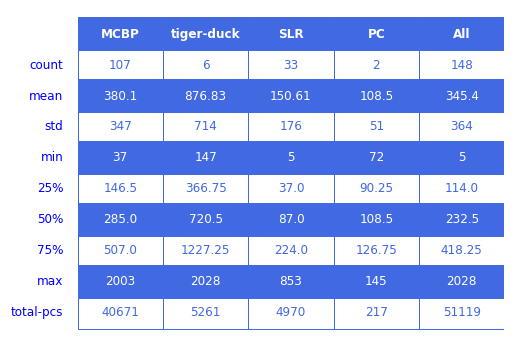

In [11]:
def headerCell(label_s, label, header_bottom, ax):
    header_cell = mpatch.Rectangle(
            (label_s,header_bottom),
            .18, .1, alpha=1, facecolor="royalblue", edgecolor= "royalblue")
    rx, ry = header_cell.get_xy()
    cx = rx + header_cell.get_width()/2.0
    cy = ry + header_cell.get_height()/2.0
    ax.add_patch(header_cell)
    ax.annotate(label, (cx, cy), color='w', weight='bold', 
            fontsize=12, ha='center', va='center')
def tableCell(label_s, label, row_height, faceColor, edgeColor, fontColor, fontWeight, alpha, ax):
    table_cell = mpatch.Rectangle(
        (label_s,row_height),
        .18, .1, alpha=1, facecolor=faceColor, edgecolor=edgeColor)
    rx, ry = table_cell.get_xy()
    cx = rx + table_cell.get_width()/2.0
    cy = ry + table_cell.get_height()/2.0
    ax.add_patch(table_cell)
    ax.annotate(label, (cx, cy), color=fontColor, weight=fontWeight, 
            fontsize=12, ha='center', va='center')
def rowHeader(label_s, label, row_height,faceColor, edgeColor, alpha, ax):
    table_cell = mpatch.Rectangle(
        (label_s,row_height),
        .12, .1, alpha=1, facecolor=faceColor, edgecolor= edgeColor)
    rx, ry = table_cell.get_xy()
    cx = rx + table_cell.get_width()/2.0
    cy = ry + table_cell.get_height()/2.0
    ax.add_patch(table_cell)
    ax.annotate(label, (cx, cy), color='b', weight='normal', 
            fontsize=12, ha='right', va='center')  

def makeTable(header, the_rows, header_bottom):
    fig = plt.figure(figsize=(8.5,6))
    ax = fig.add_subplot(111)
    header_bottom=.88
    cell_width = .18
    for i,label in enumerate(header):
        if i == 0:
            label_start = .1
            headerCell(label_start, label,header_bottom, ax)
        else:
            label_start = .1 + (i*.18)
            headerCell(label_start, label,header_bottom, ax)
    for k,x in enumerate(the_rows):
        cell_height=.095
        label_start = .1
        cell_width = .18
        if k == 0:
            row_height = header_bottom-cell_height        
            for j,value in enumerate(the_rows[x]):
                if j == 0:                
                    label_start = .1
                    tableCell(
                        label_start,
                        value,
                        row_height,
                        "none",
                        "royalblue",
                        "royalblue",
                        "normal",
                        1, ax)

                else:
                    label_start = .1 + (j*cell_width)
                    tableCell(
                        label_start,
                        value,
                        row_height,
                        "none",
                        "royalblue",
                        "royalblue",
                        "normal",
                        1, ax)
        else:
            row_height = header_bottom-cell_height-(cell_height*k)
            if k%2 != 0:        
                for j,value in enumerate(the_rows[x]):
                    if j == 0:
                        label_start = .1
                        tableCell(
                            label_start,
                            value,
                            row_height,
                            "royalblue",
                            "royalblue",
                            "white",
                            "normal",
                            1, ax
                        )
                    else:
                        label_start = .1 + (j*cell_width)
                        tableCell(
                            label_start,
                            value,
                            row_height,
                            "royalblue",
                            "royalblue",
                            "white",
                            "normal",
                            1, ax
                        )
            else:
                for j,value in enumerate(the_rows[x]):
                    if j == 0:
                        label_start = .1
                        tableCell(
                            label_start,
                            value,
                            row_height,
                            "none",
                            "royalblue",
                            "royalblue",
                            "normal",
                            1, ax
                        )
                    else:
                        label_start = .1 + (j*cell_width)
                        tableCell(
                            label_start,
                            value,
                            row_height,
                            "none",
                            "royalblue",
                            "royalblue",
                            "normal",
                            1, ax
                        )
    for n,x in enumerate(list(the_rows.keys())):
        label_start = .01
        cell_height=.095
        if n == 0:
            row_height = header_bottom-cell_height  
            rowHeader(label_start, x, row_height,"none", "none", 1, ax)   
        else:
            row_height = header_bottom-cell_height-(cell_height*n)
            rowHeader(label_start, x,row_height, "none", "none", 1, ax) 

    ax.axis("off")
    plt.show()
makeTable(header, the_rows, .88)

### Year one Nov 2015 - Nov 2016

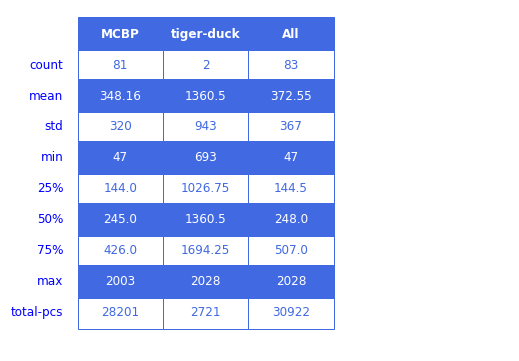

In [12]:
year_one_data = daily_quantity.loc[idx[:,:,year_one_end_start[0][0]:year_one_end_start[0][1]], :]
projct_names = list(year_one_data.index.get_level_values(0))
all_data_summary = getAnnualSummaries(project_names,year_one_data)
the_rows, header = makeRows(all_data_summary)
makeTable(header, the_rows, .88)

### Year two Nov 2016 - Nov 2017

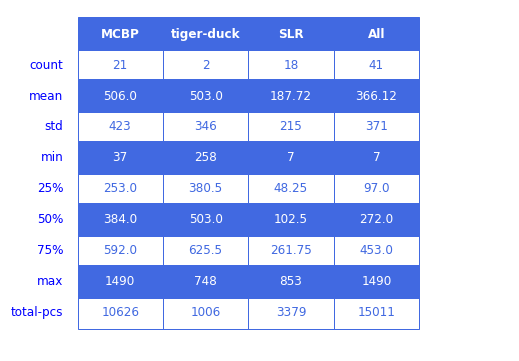

In [13]:
year_two_data = daily_quantity.loc[idx[:,:,year_two_end_start[0][0]:year_two_end_start[0][1]], :]
projct_names = list(year_two_data.index.get_level_values(0))
all_data_summary = getAnnualSummaries(project_names,year_two_data)
the_rows, header = makeRows(all_data_summary)
makeTable(header, the_rows, .88)

### Year three Nov 2017 - Nov 2018

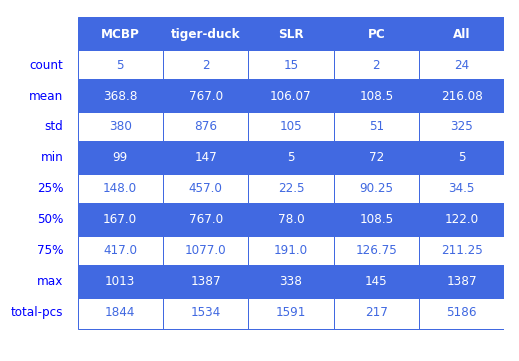

In [14]:
year_three_data = daily_quantity.loc[idx[:,:,year_three_end_start[0][0]:year_three_end_start[0][1]], :]
projct_names = list(year_three_data.index.get_level_values(0))
all_data_summary = getAnnualSummaries(project_names,year_three_data)
the_rows, header = makeRows(all_data_summary)
makeTable(header, the_rows, .88)